In [1]:
from qiskit import *
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.jobstatus import JOB_FINAL_STATES
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise
import qiskit.ignis.verification.tomography as tomo
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Qubit, Clbit

import numpy as np
%matplotlib inline
import pickle
import time
from copy import deepcopy
import collections
import statistics

In [3]:
IBMQ.save_account("9dc5c937fcedf3575d64912c02715c0ec0e27043cf5f18040b0304cdd16dac2ea042ffecad4b007b245926a694f92a9ebfdc1ede6b381b004a2fe0ed2cf262b1")
provider = IBMQ.load_account()
sv_sim = qiskit.Aer.get_backend('statevector_simulator')
melbourne = provider.get_backend(name='ibmq_16_melbourne')
sim = provider.get_backend(name='ibmq_qasm_simulator')

configrc.store_credentials:WARNING:2020-05-09 05:41:23,285: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2020-05-09 05:41:23,509: Credentials are already in use. The existing account in the session will be replaced.


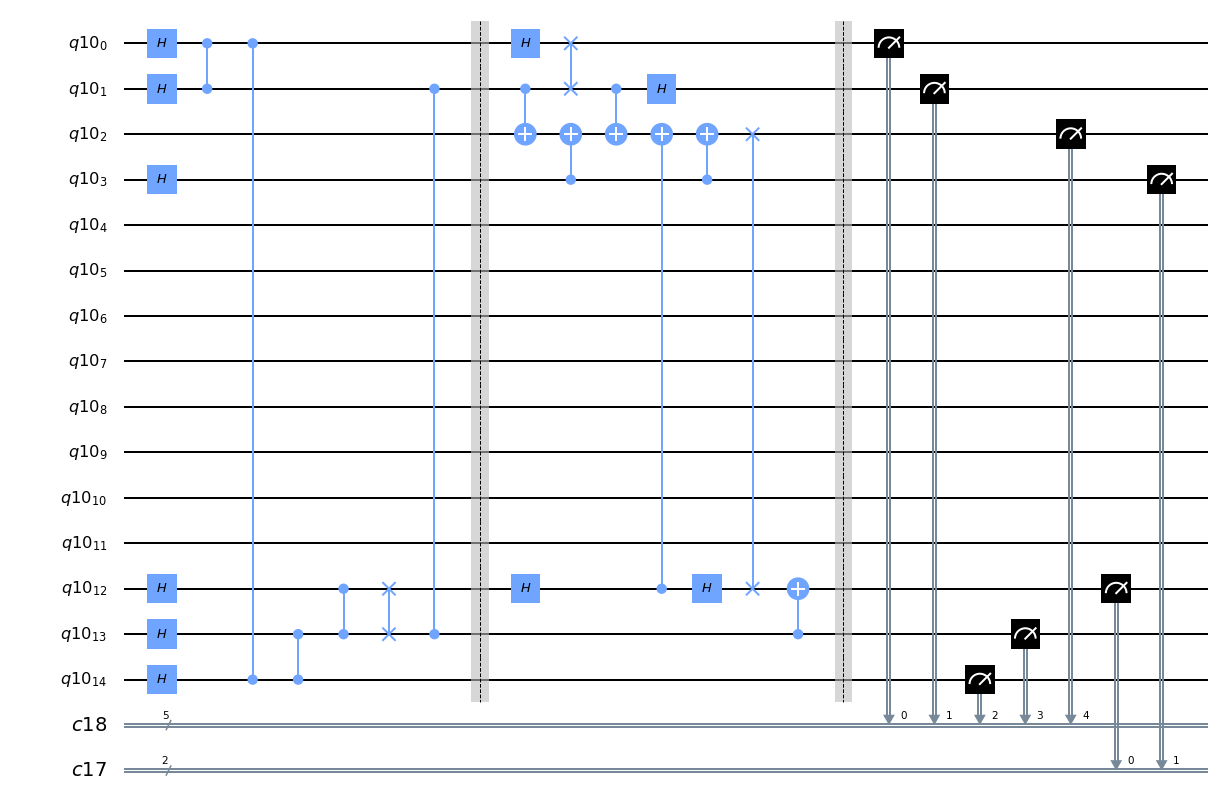

In [55]:
qr = QuantumRegister(15)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr)
qenc = QuantumCircuit(5)

for i in range(5):
    qenc.h(i)

for i in range(5):
    if i != 4:
        qenc.cz(i,i+1)
    else:
        qenc.cz(4,0)

eff_qubits = [0, 1, 2, 3, 12, 13, 14]
for i in eff_qubits:
    if i != 2:
        qc.h(qr[i])
        
qc.cz(qr[1],qr[0])
qc.cz(qr[0],qr[14])
qc.cz(qr[14],qr[13])
qc.cz(qr[13],qr[12])
qc.swap(qr[13],qr[12])
qc.cz(qr[13],qr[1])
qc.barrier()

qc.h(qr[0])
qc.h(qr[12])
qc.cx(qr[1],qr[2])
qc.swap(qr[0],qr[1])
qc.cx(qr[3],qr[2])
qc.cx(qr[1],qr[2])
qc.h(qr[1])
qc.cx(qr[12],qr[2])
qc.cx(qr[3],qr[2])
qc.h(qr[12])
qc.swap(qr[12],qr[2])
qc.cx(qr[13],qr[12])


qc_tomo = tomo.state_tomography_circuits(qc, [qr[0],qr[1],qr[14],qr[13],qr[2]])
qc_tomo_no_anc = deepcopy(qc_tomo)

for qcirc in qc_tomo:
    qcirc.add_register(cr)
    qcirc.measure(qr[12],cr[0])
    #qcirc.h(qr[3])
    qcirc.measure(qr[3],cr[1])
    
qc_tomo[242].draw(output = 'mpl')

In [56]:
# state vector simulation
job_svsim = execute(qenc, backend = sv_sim)
psi = job_svsim.result().get_statevector(qenc)
print(len(psi))

32


In [57]:
#Running on QC
job = execute(qc_tomo, backend = sim, optimization_level = 3, shots = 4096)

start_time = time.time()
job_status = job.status()
while job_status not in JOB_FINAL_STATES:
    print(f'Status @ {time.time() - start_time:0.0f} s: {job_status},'f' ')
    time.sleep(1)
    job_status = job.status()

raw_results = job.result()
new_result = deepcopy(raw_results)

Status @ 0 s: JobStatus.VALIDATING, 
Status @ 2 s: JobStatus.VALIDATING, 
Status @ 3 s: JobStatus.VALIDATING, 
Status @ 4 s: JobStatus.VALIDATING, 
Status @ 6 s: JobStatus.VALIDATING, 
Status @ 7 s: JobStatus.VALIDATING, 
Status @ 8 s: JobStatus.VALIDATING, 
Status @ 9 s: JobStatus.VALIDATING, 
Status @ 11 s: JobStatus.RUNNING, 
Status @ 12 s: JobStatus.RUNNING, 
Status @ 13 s: JobStatus.RUNNING, 
Status @ 15 s: JobStatus.RUNNING, 
Status @ 16 s: JobStatus.RUNNING, 


In [58]:
flag = []
syndrome = []
for resultidx, _ in enumerate(raw_results.results):
    old_counts = raw_results.get_counts(resultidx)
    new_counts = {}
    
    #change the size of the classical register
    new_result.results[resultidx].header.creg_sizes = [new_result.results[resultidx].header.creg_sizes[0]]
    new_result.results[resultidx].header.clbit_labels = new_result.results[resultidx].header.clbit_labels[0:-2]
    new_result.results[resultidx].header.memory_slots = 5
    
    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        flag.append(reg_bits[0][0])
        syndrome.append(reg_bits[0][1])
        new_counts[reg_bits[1]] = old_counts[reg_key]

    new_result.results[resultidx].data.counts = new_result.results[resultidx].data.counts.from_dict(new_counts)

flag = statistics.mode(flag)
syndrome = statistics.mode(syndrome)

In [59]:
tomo_fitter = tomo.StateTomographyFitter(new_result, qc_tomo_no_anc)
rho = tomo_fitter.fit(method = 'lstsq')

# Fidelity
fidelity = state_fidelity(psi, rho)
print('Fit Fidelity =', fidelity)

Fit Fidelity = 0.24834602827477387
